# Measuring information loss when modeling sick leave with weight mixture models

Margaux Thorez

In this article, we consider a problem in actuarial sciences, in which we have M insurance companies (samples) and K groups of insured persons. We want to model sick leave for each group. However, the group label of each observation is not defined with certainty for confidential reasons. We assume that each insurance company can provide the proportion of each group in its database. In this case, we are going to compare two different Kaplan-Meier estimators for mixture models. We measure the information loss when modeling sick leaves with variable weight mixture models in censored duration models, comparing Ryzhov's and Maiboroda's methods, both using simulations and empirical data. 

Here are the codes used for the simulations for differents kind of function : exponnential law, Pareto's law, Weibull's law, Gamma's law. 


## 1- Contextualization

### Ryzhov's method

Case of 2 insurers (A and B) and 2 sub-populations (1 and 2) :

The objective is to study the censoring model in the case of a weighted mixture model. We assume two data sets A and B (of sizes $n_A$ and $n_B$ respectively, with $ n = n_A + n_B $) and two subpopulations 1 and 2, with survival functions $S_1 $ and $ S_2$ respectively, which we seek to estimate. Denoting $P_{A1}, P_{A2}, P_{B1} $ and $ P_{B2} $ the weights of each subpopulation in each population, we have :

$\hat S_A (y) = P_{A1} \hat S_1 (y) + P_{A2} \hat S_2 (y) $

$\hat S_B (y) = P_{B1} \hat S_1 (y) + P_{B2} \hat S_2 (y) $

Survival models: estimation of $\hat S_1$ and $\hat S_2$ :

In our example, we have :

$\hat S_A (y) = P_{A1} \hat S_1 (y) + P_{A2} \hat S_2 (y) $

$\hat S_B (y) = P_{B1} \hat S_1 (y) + P_{B2} \hat S_2 (y) $

So, in matrix form, we have $ M A = B $ with $M$ the weight matrix, $A$ the matrix with $\hat S_1 $ and $\hat S_2 $ and $B$ the matrix with $\hat S_A $ and $\hat S_B $.

All we have to do is invert the matrix M to obtain $ A = M^{-1} B $.

### Maiboroda's method

When applying Maiboroda's method, we no longer have 2 or 3 distinct insurers with a different proportion of each sub-group for each insurer, but a probability of belonging to each sub-group for each individual. We therefore look for $a_1$ and $a_2$ such that :

$\frac{1}{n} \sum^n_{k=1} a_1(k) p_1(k) = 1$

$\frac{1}{n} \sum^n_{k=1} a_1(k) p_2(k) = 0$

and 

$\frac{1}{n} \sum^n_{k=1} a_2(k) p_1(k) = 0$

$\frac{1}{n} \sum^n_{k=1} a_2(k) p_2(k) = 1$

## 2- Libraries import

In [1]:
#Libraries import
#Basic librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import *
from scipy import stats
import random
import statistics

#scikit-survival Kaplan-Meier estimator
from sksurv.nonparametric import kaplan_meier_estimator

#Interpolation
from scipy.interpolate import interp1d

#CVXPY for convex optimization problems.
import cvxpy as cp

#Numba import
from numba import njit, vectorize

#Parallelization modules
from sklearn.utils._joblib import Parallel, delayed

#Notebook
from jyquickhelper import add_notebook_menu
import warnings
warnings.filterwarnings('ignore')

In [2]:
add_notebook_menu()

## 3- Optimized functions

For the law parameter choice, we have to choose the parameter "law" among "exponnential", "pareto", "weibull" and "gamma". 

### Survival functions

In [3]:
#Survival functions : returns the survival function of a mixture model for a certain law
def S(x,P1,P2,law,lambd1,lambd2):
    if law == "exponnential":
        S = P1*stats.expon.sf(x, scale=lambd1) + P2*stats.expon.sf(x, scale=lambd2)
    if law == "pareto":
        #Certain parameters of the Pareto law have been fixed in order to obtain a function with characteristics similar to the survival functions found for sick leaves
        S = P1*stats.pareto.sf(x, b=3, loc = -(2/3)*lambd1, scale=(2/3)*lambd1) + P2*stats.pareto.sf(x, b=3, loc=-(2/3)*lambd2, scale=(2/3)*lambd2)
    if law == "weibull":
        #Certain parameters of the Weibull law have been fixed in order to obtain a function with characteristics similar to the survival functions found for sick leaves
        S = P1*stats.weibull_min.sf(x, c=2, scale=lambd1) + P2*stats.weibull_min.sf(x, c=2, scale=lambd2)
    if law == "gamma":
        S = P1*stats.gamma.sf(x, a=lambd1) + P2*stats.gamma.sf(x, a=lambd2)
    return(S)

### Simulation functions

In [4]:
#Function that creates the base sample in a mixture according to the chosen law
def InitializeMatriceX(law, lambd1, lambd2, P_1, size):
    #Matrices X_A1 and X_A2
    if law == "exponnential":
        X_1 = stats.expon.rvs(scale=lambd1, size=size)
        X_2 = stats.expon.rvs(scale=lambd2, size=size)
    if law == "pareto":
        X_1_v1 = stats.pareto.rvs(b=3, size=size)
        X_1 = (2/3)*lambd1*(X_1_v1-1)
        X_2_v1 = stats.pareto.rvs(b=3, size=size)
        X_2 = (2/3)*lambd2*(X_2_v1-1)
    if law == "weibull":
        X_1 = stats.weibull_min.rvs(c=2, scale=lambd1, size=size)
        X_2 = stats.weibull_min.rvs(c=2, scale=lambd2, size=size)    
    if law == "gamma" :
        X_1 = stats.gamma.rvs(a=lambd1, size=size)
        X_2 = stats.gamma.rvs(a=lambd2, size=size)
    #Matrice RA
    R = stats.bernoulli.rvs(P_1, size=size)
    X = R*X_1 + (1-R)*X_2
    return X

In [5]:
#Function to include censorship
@njit #(parallel=True)
def Y_ind_Allocation(Y_ind, Y, C, X):
    for i in range(len(X)):
        if Y[i]<C[i]: 
            Y_ind[i]=True
    return Y_ind

In [6]:
#Function to interpolate survival functions
def S_est_Actualisation(S_est, time, time1, t):
    S_est_res = np.concatenate(([1], S_est,[0]))
    f = interp1d(np.concatenate(([0], time,[t])), S_est_res)
    S_est_res = f(time1)
    return S_est_res

### Kaplan-Meier function of Maiboroda

In [7]:
#Function to count S_X and N_X variables for Maiboroda's estimator
@njit #(parallel=True)
def S_x_N_x_Allocation(Y,Y_ind,X_X,time):
    S_X = np.zeros_like(time)
    N_X = np.zeros_like(time)
    for k, t_k in enumerate(time):
        for i, Y_i in enumerate(Y):
            if Y_i >= t_k:
                S_X[k] += X_X[i]
            if (Y_i <= t_k) and  (Y_ind[i]==True) : 
                N_X[k] += X_X[i]
    return S_X, N_X

In [8]:
#Function to determine Maiboroda's estimator having S_X and N_X
@njit #(parallel=True)
def S_1_mx_Allocation(Y, S_X, N_X, time):
    # Initialisation
    S_1_mx = np.ones_like(time)
    for k, t_k in enumerate(time):
        for i in range(1,k):
            if (Y[i] <= t_k) and (S_X[i] != 0) :
                S_1_mx[k] = S_1_mx[k] * (1 - (N_X[i] - N_X[i-1])/S_X[i])
    return S_1_mx

In [9]:
#Function to smooth a survival function
@njit #(parallel=True)
# direction = 0 ou 1
def S_1_est_mx_Threshold(S_1_est_mx, direction):
    S1_res = np.zeros_like(S_1_est_mx)
    #Maximum at 1 and minimum at 0 for the survival function
    for i, item in enumerate(S_1_est_mx):
        if item > 1 :
            S1_res[i] = 1
        elif item < 0 :
            S1_res[i] = 0
        else :
            S1_res[i] = item
    #If direction = 0, we give to S[t] the value of S[t+1] if S[t]<S[t+1]
    if direction == 0 : 
        for i in range(len(S_1_est_mx)-1):
            k = i+1
            while k<len(S_1_est_mx):
                if S1_res[i]<S1_res[k]:
                    S1_res[i] = S1_res[k]
                k+=1
    #If direction = 1, we give to S[t+1] the value of S[t] if S[t]<S[t+1]
    elif direction == 1 :
        for i in range(len(S_1_est_mx)-1):
            k = i+1
            while k < len(S_1_est_mx):
                if S1_res[i]<S1_res[k]:
                    S1_res[k] = S1_res[i]
                k+=1
    return S1_res

In [10]:
#Maiboroda's Kaplan-Meier estimator
@njit #(parallel=True)
def kaplan_meier_mx (Y,Y_ind,X_X,time, direction) :
    #Construction of N_X and S_X
    S_X, N_X = S_x_N_x_Allocation(Y=Y,Y_ind=Y_ind,X_X=X_X,time=time)
    #Initialization of S_1_est_mx
    S_1_est_mx = S_1_mx_Allocation(Y=Y, S_X=S_X, N_X=N_X, time=time)
    return S_1_est_mx 

In [11]:
#Maiboroda's Kaplan-Meier estimator smoothed
@njit #(parallel=True)
def kaplan_meier_mx_smoothed (Y,Y_ind,X_X,time, direction) :
    #Construction of N_X and S_X
    S_X, N_X = S_x_N_x_Allocation(Y=Y,Y_ind=Y_ind,X_X=X_X,time=time)
    #Initialization of S_1_est_mx
    S_1_est_mx = S_1_mx_Allocation(Y=Y, S_X=S_X, N_X=N_X, time=time)
    #S_1_est_mx thresholding
    S_1_est_mx_res = S_1_est_mx_Threshold(S_1_est_mx, direction)
    #Return S_1_est_mx_res if we want the survival function to be linearized, S_1_est_mx otherwise
    return S_1_est_mx_res 

## 4- Simulations

### Parameters choice

In [12]:
#Parameters choice (choose among "exponnential", "pareto", "weibull" and "gamma")
law = "exponnential" 

#Sample sizes (we have chosen nA = nB but it is possible to change these parameters)
n = 10000
nA = round(n/2)
nB = n - nA

#Mixture parameters
lambd1 = 50
lambd2 = 30

#Censorship parameters
lambdC = 40

#Weight selection (note that we must have P_A1 + P_A2 = 1 and P_B1 + P_B2 = 1)
P_A1 =0.7
P_A2 =0.3 
P_B1 =0.1
P_B2 =0.9

#Threshold direction
direction = 1

### Inverted weight matrix

In [13]:
#Inverted weight matrix
M = np.array([[P_A1, P_A2],[P_B1, P_B2]])
M_inv = np.linalg.inv(M)
print(M_inv)

[[ 1.5        -0.5       ]
 [-0.16666667  1.16666667]]


### Simulation of observations

In [14]:
#Initialization of matrices X_A and X_B
X_A = InitializeMatriceX(law=law, lambd1=lambd1, lambd2=lambd2, P_1=P_A1, size=nA)
X_B = InitializeMatriceX(law=law, lambd1=lambd1, lambd2=lambd2, P_1=P_B1, size=nB)

In [15]:
#Mean of true values
print(np.mean(X_A))
print(np.mean(X_B))

43.1052017017845
32.17060482334173


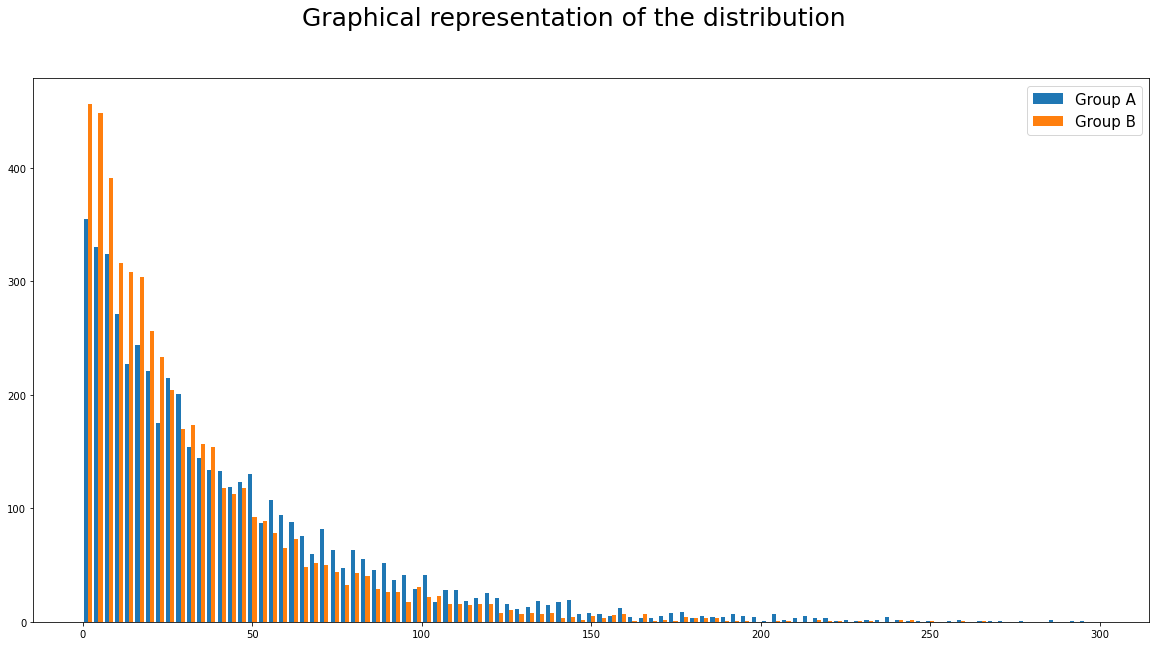

In [16]:
#Graphical representation of the distribution
fig, ax = plt.subplots(figsize=(20, 10)) 
plt.style.use('seaborn-deep')
fig.suptitle("Graphical representation of the distribution", fontsize = 25)
bins = np.linspace(0, 300, 100)
plt.hist([X_A, X_B], bins, label=['Group A', 'Group B'])
plt.legend(loc='upper right', fontsize = 15)
plt.show()

In [17]:
#Initialization of matrices C_A and C_B
C_A = InitializeMatriceX(law=law, lambd1=lambdC, lambd2=lambdC, P_1=1, size=nA)
C_B = InitializeMatriceX(law=law, lambd1=lambdC, lambd2=lambdC, P_1=1, size=nB)

In [18]:
#Mean of censorship
print(np.mean(C_A))
print(np.mean(C_B))

39.46228463567889
39.82899429864267


### Ryzhov's method

In [19]:
##Ryzhov
#Independent copy of X_A and X_B
Y_A = X_A
Y_B = X_B
#Initializing Y_A_ind and Y_B_ind
Y_A_ind = np.full(shape=Y_A.shape, fill_value=False)
Y_B_ind = np.full(shape=Y_B.shape, fill_value=False)
#Updating Y_A_ind and Y_B_ind
Y_A = np.minimum(C_A, X_A)
Y_A_ind = Y_ind_Allocation(Y_ind=Y_A_ind, Y=Y_A, C=C_A, X=X_A)
Y_B = np.minimum(C_B, X_B)
Y_B_ind = Y_ind_Allocation(Y_ind=Y_B_ind, Y=Y_B, C=C_B, X=X_B)

In [20]:
#Observations means
print(np.mean(Y_A))
print(np.mean(Y_B))

20.409928992571267
17.441880465126744


In [21]:
#Kaplan-Meier estimator
time_A, S_A_est = kaplan_meier_estimator(Y_A_ind, Y_A)
time_B, S_B_est = kaplan_meier_estimator(Y_B_ind, Y_B)
#Initialization of time1, t and M_inv
time1 = np.concatenate(([0],time_A, time_B))
time1.sort()
t=max(time_A[-1],time_B[-1])
#Interpolation of S_A_est and S_B_est
S_A_est = S_est_Actualisation(S_est=S_A_est, time=time_A, time1=time1, t=t)
S_B_est = S_est_Actualisation(S_est=S_B_est, time=time_B, time1=time1, t=t)
#Determination of S_1_est and S_2_est (following Ryzhov's method)
S_1_est = M_inv[0][0]*S_A_est + M_inv[0][1]*S_B_est
S_2_est = M_inv[1][0]*S_A_est + M_inv[1][1]*S_B_est

In [22]:
#KS norms for Ryzhov's estimators
KS_1_Ryzhov = np.linalg.norm(S(time1,1,0,law,lambd1,lambd2) - S_1_est , np.inf) 
KS_2_Ryzhov = np.linalg.norm(S(time1,0,1,law,lambd1,lambd2) - S_2_est , np.inf)
print("Results for Ryzhov's estimators: ")
print("KS_1_Ryzhov : " + str(KS_1_Ryzhov))
print("KS_2_Ryzhov : " + str(KS_2_Ryzhov))

Results for Ryzhov's estimators: 
KS_1_Ryzhov : 0.04178799098468641
KS_2_Ryzhov : 0.02381196182028454


### Maiboroda's method

In [23]:
##Maiboroda
#Initialization of matrices X, C, Y and Y_ind
X = np.concatenate((X_A,X_B))  
C = np.concatenate((C_A,C_B)) 
Y = X
Y_ind = np.full(shape=Y.shape, fill_value=False)
#Updating Y_ind
Y = np.minimum(C, X)
Y_ind = Y_ind_Allocation(Y_ind=Y_ind, Y=Y, C=C, X=X)
#Sorting Y
m = Y.argsort()
Y = Y[m]

In [24]:
#Maiboroda's coefficients
if nA == nB:
    #This method can be use when na = nB
    X_1 = [2*M_inv[0][0] for i in range(0,nA)] + [2*M_inv[0][1] for i in range(0,nB)]
    X_2 = [2*M_inv[1][0] for i in range(0,nA)] + [2*M_inv[1][1] for i in range(0,nB)]
    X_1 = np.array(X_1)
    X_2 = np.array(X_2)
else : 
    #This method is more time-consuming but is true in the general case. 
    prob_X1 = [P_A1 for i in range(0,n1)] + [P_B1 for i in range(0,n2)]
    prob_X2 = [P_A2 for i in range(0,n1)] + [P_B2 for i in range(0,n2)]
    A = np.asmatrix([prob_X1,prob_X2])
    A_trans = np.transpose(A)
    N = A.shape[1]
    X = cp.Variable(N)
    prob = cp.Problem(cp.Minimize(cp.sum(X)), [A @ X == [n , 0] ])
    prob.solve(solver = cp.SCS, verbose=True)
    X_1 = X.value
    N = A.shape[1]
    X = cp.Variable(N)
    prob = cp.Problem(cp.Minimize(cp.sum(X)), [A @ X == [0 , n] ])  
    prob.solve(solver = cp.SCS, verbose=True)
    X_2 = X.value
    X_1 = np.array(X_1)
    X_2 = np.array(X_2)

In [25]:
#Kaplan-Meier estimator
time2, S_est = kaplan_meier_estimator(Y_ind, Y)
#Construction of S_mx using our Kaplan Meier estimator 
S_1_mx = kaplan_meier_mx(Y=Y,Y_ind=Y_ind,X_X=X_1[m],time=time1, direction=direction)
S_2_mx = kaplan_meier_mx(Y=Y,Y_ind=Y_ind,X_X=X_2[m],time=time1, direction=direction)

In [26]:
#KS norms for Maiboroda's estimators
KS_1_Maiboroda = np.linalg.norm(S(time1,1,0,law,lambd1,lambd2) - S_1_mx , np.inf)
KS_2_Maiboroda = np.linalg.norm(S(time1,0,1,law,lambd1,lambd2) - S_2_mx , np.inf)
print("Results for Maiboroda's estimators: ")
print("KS_1_Maiboroda : " + str(KS_1_Maiboroda))
print("KS_2_Maiboroda : " + str(KS_2_Maiboroda))

Results for Maiboroda's estimators: 
KS_1_Maiboroda : 0.08679868094276935
KS_2_Maiboroda : 0.04511671144437046


In [27]:
#Smoothed Maiboroda's estimator
time2, S_est = kaplan_meier_estimator(Y_ind, Y)
#Construction of S_mx_smoothed using our smoothed Kaplan Meier estimator 
S_1_mx_smoothed = kaplan_meier_mx_smoothed(Y=Y,Y_ind=Y_ind,X_X=X_1[m],time=time1, direction=direction)
S_2_mx_smoothed = kaplan_meier_mx_smoothed(Y=Y,Y_ind=Y_ind,X_X=X_2[m],time=time1, direction=direction)

In [28]:
#KS norms for Maiboroda's smoothed estimators
KS_1_Maiboroda_smoothed = np.linalg.norm(S(time1,1,0,law,lambd1,lambd2) - S_1_mx_smoothed , np.inf)
KS_2_Maiboroda_smoothed = np.linalg.norm(S(time1,0,1,law,lambd1,lambd2) - S_2_mx_smoothed , np.inf)
print("Results for Maiboroda's smoothed estimators: ")
print("KS_1_Maiboroda : " + str(KS_1_Maiboroda_smoothed))
print("KS_2_Maiboroda : " + str(KS_2_Maiboroda_smoothed))

Results for Maiboroda's smoothed estimators: 
KS_1_Maiboroda : 0.08679868094276935
KS_2_Maiboroda : 0.04501846257412068


### Results comparison

In this section, you can change S_1_mx_smoothed by S_1_mx if you want to compare this second estimator with Ryzhov's one. 

In [29]:
#Gap between Maiboroda and Ryzhov for Group 1 
Gap_1 = np.linalg.norm(S_1_est - S_1_mx_smoothed , np.inf)
print("Gap between Maiboroda and Ryzhov for Group 1  : " + str(Gap_1))

Gap between Maiboroda and Ryzhov for Group 1  : 0.09969642973600534


In [30]:
#Gap between Maiboroda and Ryzhov for Group 2
Gap_2 = np.linalg.norm(S_2_est - S_2_mx_smoothed , np.inf)
print("Gap between Maiboroda and Ryzhov for Group 2  : " + str(Gap_2))

Gap between Maiboroda and Ryzhov for Group 2  : 0.048578423667331116


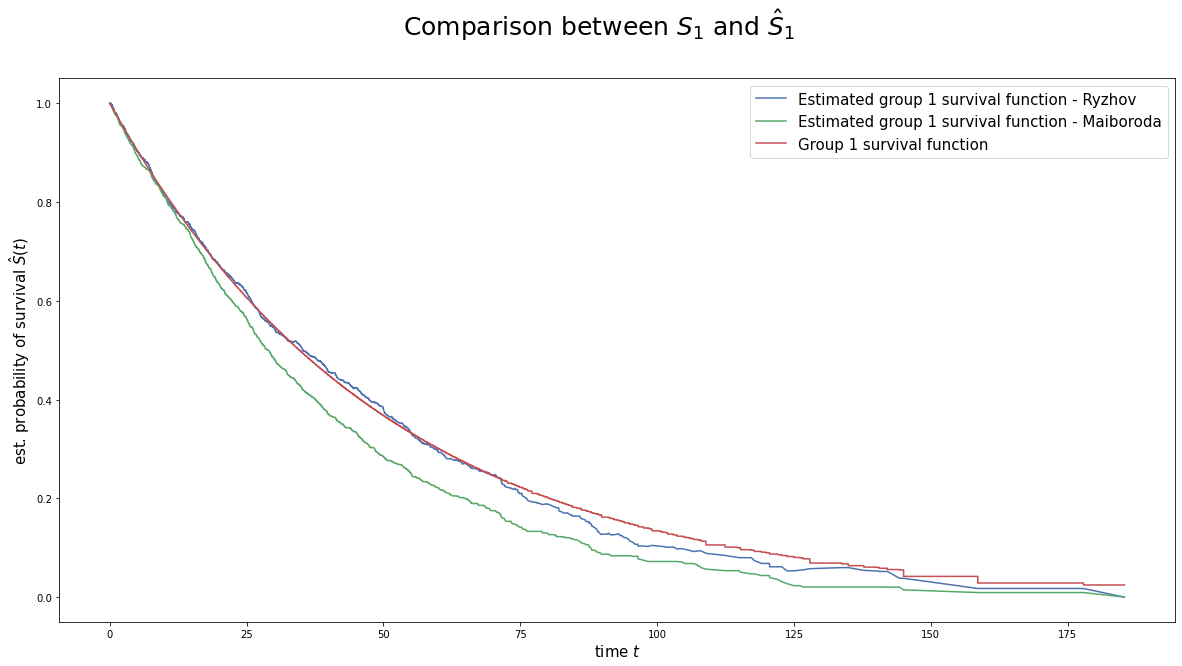

In [31]:
#Comparison between S1 and estimated S1
fig, ax = plt.subplots(figsize=(20, 10)) 
fig.suptitle("Comparison between $S_1$ and $\hat S_1$", fontsize = 25)
x=np.arange(0,max(time1), 1)
ax.plot(time1, S_1_est, label="Estimated group 1 survival function - Ryzhov")
ax.plot(time1, S_1_mx_smoothed, label="Estimated group 1 survival function - Maiboroda")
ax.step(time1,S(time1,1,0,law,lambd1,lambd2), label="Group 1 survival function")
ax.legend(fontsize = 15)
plt.ylabel("est. probability of survival $\hat{S}(t)$",fontsize = 15)
plt.xlabel("time $t$",fontsize = 15)
plt.show()

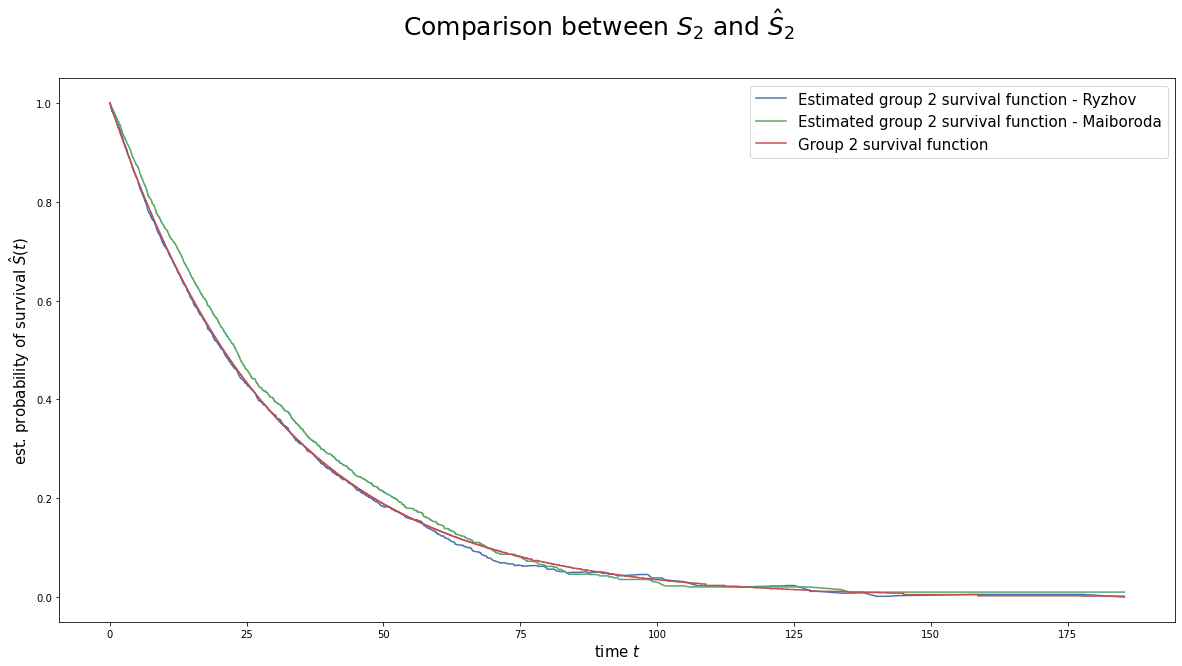

In [32]:
#Comparison between S2 and estimated S2
fig, ax = plt.subplots(figsize=(20, 10)) 
fig.suptitle("Comparison between $S_2$ and $\hat S_2$", fontsize = 25)
x=np.arange(0,max(time1), 1)
ax.plot(time1, S_2_est, label="Estimated group 2 survival function - Ryzhov")
ax.plot(time1, S_2_mx_smoothed, label="Estimated group 2 survival function - Maiboroda")
ax.step(time1,S(time1,0,1,law,lambd1,lambd2), label="Group 2 survival function")
ax.legend(fontsize = 15)
plt.ylabel("est. probability of survival $\hat{S}(t)$", fontsize = 15)
plt.xlabel("time $t$", fontsize = 15)
plt.show()

## 5- Simulation automation

K simulations are performed for each possible weight choice 

### Additional functions 

In [33]:
def RunSimulation(nA, nB, law, lambd1, lambd2, lambdC, P_A1, P_A2, P_B1, P_B2, S, M_inv, X_1, X_2, direction, smoothed):
    #Simulation of observations
    #Initialization of matrices X_A and X_B
    X_A = InitializeMatriceX(law=law, lambd1=lambd1, lambd2=lambd2, P_1=P_A1, size=nA)
    X_B = InitializeMatriceX(law=law, lambd1=lambd1, lambd2=lambd2, P_1=P_B1, size=nB)
    #Initialization of matrices C_A and C_B
    C_A = InitializeMatriceX(law=law, lambd1=lambdC, lambd2=lambdC, P_1=1, size=nA)
    C_B = InitializeMatriceX(law=law, lambd1=lambdC, lambd2=lambdC, P_1=1, size=nB)
    
    ##Ryzhov
    #Independent copy of X_A and X_B
    Y_A = X_A
    Y_B = X_B
    #Initializing Y_A_ind and Y_B_ind
    Y_A_ind = np.full(shape=Y_A.shape, fill_value=False)
    Y_B_ind = np.full(shape=Y_B.shape, fill_value=False)
    #Updating Y_A_ind and Y_B_ind
    Y_A = np.minimum(C_A, X_A)
    Y_A_ind = Y_ind_Allocation(Y_ind=Y_A_ind, Y=Y_A, C=C_A, X=X_A)
    Y_B = np.minimum(C_B, X_B)
    Y_B_ind = Y_ind_Allocation(Y_ind=Y_B_ind, Y=Y_B, C=C_B, X=X_B)
    #Kaplan-Meier estimator
    time_A, S_A_est = kaplan_meier_estimator(Y_A_ind, Y_A)
    time_B, S_B_est = kaplan_meier_estimator(Y_B_ind, Y_B)
    #Initialization of time1, t and M_inv
    time1 = np.concatenate(([0],time_A, time_B))
    time1.sort()
    t=max(time_A[-1],time_B[-1])
    #Interpolation of S_A_est and S_B_est
    S_A_est = S_est_Actualisation(S_est=S_A_est, time=time_A, time1=time1, t=t)
    S_B_est = S_est_Actualisation(S_est=S_B_est, time=time_B, time1=time1, t=t)
    #Determination of S_1_est and S_2_est (following Ryzhov's method)
    S_1_est = M_inv[0][0]*S_A_est + M_inv[0][1]*S_B_est
    S_2_est = M_inv[1][0]*S_A_est + M_inv[1][1]*S_B_est
    #KS norms for Ryzhov's estimators
    KS_1_Ryzhov = np.linalg.norm(S(time1,1,0,law,lambd1,lambd2) - S_1_est , np.inf) 
    KS_2_Ryzhov = np.linalg.norm(S(time1,0,1,law,lambd1,lambd2) - S_2_est , np.inf)
    
    ## Maiboroda
    #Initialization of matrices X, C, Y and Y_ind
    X = np.concatenate((X_A,X_B))  
    C = np.concatenate((C_A,C_B)) 
    Y = X
    Y_ind = np.full(shape=Y.shape, fill_value=False)
    #Updating Y_ind
    Y = np.minimum(C, X)
    Y_ind = Y_ind_Allocation(Y_ind=Y_ind, Y=Y, C=C, X=X)
    #Sorting Y
    m = Y.argsort()
    Y = Y[m]
    #Kaplan-Meier estimator
    time2, S_est = kaplan_meier_estimator(Y_ind, Y)
    if smoothed :
        #Construction of S_mx_smoothed using our smoothed Kaplan Meier estimator 
        S_1_mx_smoothed = kaplan_meier_mx_smoothed(Y=Y,Y_ind=Y_ind,X_X=X_1[m],time=time1, direction=direction)
        S_2_mx_smoothed = kaplan_meier_mx_smoothed(Y=Y,Y_ind=Y_ind,X_X=X_2[m],time=time1, direction=direction)
        #KS norms for Maiboroda's smoothed estimators
        KS_1_Maiboroda = np.linalg.norm(S(time1,1,0,law,lambd1,lambd2) - S_1_mx_smoothed , np.inf)
        KS_2_Maiboroda = np.linalg.norm(S(time1,0,1,law,lambd1,lambd2) - S_2_mx_smoothed , np.inf)
    else:
        #Construction of S_mx using our Kaplan Meier estimator 
        S_1_mx = kaplan_meier_mx(Y=Y,Y_ind=Y_ind,X_X=X_1[m],time=time2, direction=direction)
        S_2_mx = kaplan_meier_mx(Y=Y,Y_ind=Y_ind,X_X=X_2[m],time=time2, direction=direction)
        #KS norms for Maiboroda's estimators
        KS_1_Maiboroda = np.linalg.norm(S(time2,1,0,law,lambd1,lambd2) - S_1_mx , np.inf)
        KS_2_Maiboroda = np.linalg.norm(S(time2,0,1,law,lambd1,lambd2) - S_2_mx , np.inf)

    return (KS_1_Ryzhov, KS_2_Ryzhov, KS_1_Maiboroda, KS_2_Maiboroda)

In [34]:
def RunParallelSimulation(nA, nB, law, lambd1, lambd2, lambdC, P_A1, P_A2, P_B1, P_B2, S, M_inv, X_1, X_2, direction, smoothed, K, NJobs=-1, Verbose=0, PreDispatch='2*n_jobs'):
    #Initialization of parallelization parameters
    ParallelSetUp = Parallel(n_jobs=NJobs, verbose=Verbose, pre_dispatch=PreDispatch, prefer="threads")
    
    #RunSimulation
    ComputedBlocks = ParallelSetUp([delayed(RunSimulation)(nA=nA, nB=nB, law=law, lambd1=lambd1, lambd2=lambd2, lambdC=lambdC, P_A1=P_A1, P_A2=P_A2, P_B1=P_B1, P_B2=P_B2, S=S, M_inv=M_inv, X_1=X_1, X_2=X_2, direction = direction, smoothed=smoothed) for k in range(K)])

    #Concatenation into array
    List_KS_1_Ryzhov = np.array([KS_1_Ryzhov for KS_1_Ryzhov, _  , _ , _ in ComputedBlocks], dtype=np.dtype(object))
    List_KS_2_Ryzhov = np.array([KS_2_Ryzhov for _, KS_2_Ryzhov  , _ , _ in ComputedBlocks], dtype=np.dtype(object))
    List_KS_1_Maiboroda = np.array([KS_1_Maiboroda for _, _  , KS_1_Maiboroda , _ in ComputedBlocks], dtype=np.dtype(object))
    List_KS_2_Maiboroda = np.array([KS_2_Maiboroda for _, _  , _ , KS_2_Maiboroda in ComputedBlocks], dtype=np.dtype(object))
    
    #Return ComputedBlocks
    return List_KS_1_Ryzhov, List_KS_2_Ryzhov, List_KS_1_Maiboroda, List_KS_2_Maiboroda

### Simulation parameters

In [35]:
#Parameters choice (choose among "exponnential", "pareto", "weibull" and "gamma")
law = "exponnential" 

#Sample sizes (we have chosen nA = nB but it is possible to change these parameters)
n = 1000
nA = round(n/2)
nB = n - nA

#Mixture parameters
lambd1 = 50
lambd2 = 30

#Censorship parameters
lambdC = 40

#Weight(note that we must have P_A1 + P_A2 = 1 and P_B1 + P_B2 = 1)
P_A1_list = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
P_B1_list = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

#Number of repetitions
K = 100

#Smoothed parameter (True or False)
smoothed = True

#Threshold direction
direction = 1

In [36]:
#Random seed for the reproducibility 
random.seed(10)

### Simulations

In [37]:
df_mean_1_Ryzhov = pd.DataFrame(data=np.matrix(np.zeros((11,11))) , columns=P_A1_list, index =P_B1_list)
df_mean_1_Maiboroda = pd.DataFrame(data=np.matrix(np.zeros((11,11))) , columns=P_A1_list, index =P_B1_list)
df_mean_2_Ryzhov = pd.DataFrame(data=np.matrix(np.zeros((11,11))) , columns=P_A1_list, index =P_B1_list)
df_mean_2_Maiboroda = pd.DataFrame(data=np.matrix(np.zeros((11,11))) , columns=P_A1_list, index =P_B1_list)
df_st_dev_1_Ryzhov = pd.DataFrame(data=np.matrix(np.zeros((11,11))) , columns=P_A1_list, index =P_B1_list)
df_st_dev_1_Maiboroda = pd.DataFrame(data=np.matrix(np.zeros((11,11))) , columns=P_A1_list, index =P_B1_list)
df_st_dev_2_Ryzhov = pd.DataFrame(data=np.matrix(np.zeros((11,11))) , columns=P_A1_list, index =P_B1_list)
df_st_dev_2_Maiboroda = pd.DataFrame(data=np.matrix(np.zeros((11,11))) , columns=P_A1_list, index =P_B1_list)

In [38]:
#K simulations are performed for each possible weight choice 
for P_A1 in P_A1_list:
    for P_B1 in P_B1_list:
        if P_A1 == P_B1:
            df_mean_1_Ryzhov[P_A1][P_B1]= nan
            df_mean_1_Maiboroda[P_A1][P_B1]= nan
            df_mean_2_Ryzhov[P_A1][P_B1]= nan
            df_mean_2_Maiboroda[P_A1][P_B1]= nan
        else :
            #Weight estimation: 
            P_A2 = round(1 - P_A1, 1)
            P_B2 = round(1 - P_B1, 1)
            print(P_A1, P_A2, P_B1, P_B2)
            ##Ryzhov :
            M = np.array([[P_A1, P_A2],[P_B1, P_B2]])
            M_inv = np.linalg.inv(M)
            ##Maiboroda :
            if nA == nB:
                #This method can be use when na = nB
                X_1 = [2*M_inv[0][0] for i in range(0,nA)] + [2*M_inv[0][1] for i in range(0,nB)]
                X_2 = [2*M_inv[1][0] for i in range(0,nA)] + [2*M_inv[1][1] for i in range(0,nB)]
                X_1 = np.array(X_1)
                X_2 = np.array(X_2)
            else : 
                #This method is more time-consuming but is true in the general case. 
                prob_X1 = [P_A1 for i in range(0,nA)] + [P_B1 for i in range(0,nB)]
                prob_X2 = [P_A2 for i in range(0,nA)] + [P_B2 for i in range(0,nB)]
                A = np.asmatrix([prob_X1,prob_X2])
                A_trans = np.transpose(A)
                N = A.shape[1]
                X = cp.Variable(N)
                prob = cp.Problem(cp.Minimize(cp.sum(X)), [A @ X == [n , 0] ])
                prob.solve(solver = cp.SCS, verbose=True)
                X_1 = X.value
                N = A.shape[1]
                X = cp.Variable(N)
                prob = cp.Problem(cp.Minimize(cp.sum(X)), [A @ X == [0 , n] ])  
                prob.solve(solver = cp.SCS, verbose=True)
                X_2 = X.value
                X_1 = np.array(X_1)
                X_2 = np.array(X_2)
            
            List_KS_1_Ryzhov, List_KS_2_Ryzhov, List_KS_1_Maiboroda, List_KS_2_Maiboroda = RunParallelSimulation(nA=nA, nB=nB, law=law, lambd1=lambd1, lambd2=lambd2, lambdC=lambdC, P_A1=P_A1, P_A2=P_A2, P_B1=P_B1, P_B2=P_B2, S=S, K=K, M_inv=M_inv, X_1=X_1, X_2=X_2, direction=direction, smoothed=smoothed ,NJobs=-1, Verbose=0, PreDispatch='2*n_jobs')
            df_mean_1_Ryzhov[P_A1][P_B1]=round(statistics.mean(List_KS_1_Ryzhov),3)
            df_mean_1_Maiboroda[P_A1][P_B1]=round(statistics.mean(List_KS_1_Maiboroda),3)
            df_mean_2_Ryzhov[P_A1][P_B1]=round(statistics.mean(List_KS_2_Ryzhov),3)
            df_mean_2_Maiboroda[P_A1][P_B1]=round(statistics.mean(List_KS_2_Maiboroda),3)
            df_st_dev_1_Ryzhov[P_A1][P_B1]=round(statistics.pstdev(List_KS_1_Ryzhov),3)
            df_st_dev_1_Maiboroda[P_A1][P_B1]=round(statistics.pstdev(List_KS_1_Maiboroda),3)
            df_st_dev_2_Ryzhov[P_A1][P_B1]=round(statistics.pstdev(List_KS_2_Ryzhov),3)
            df_st_dev_2_Maiboroda[P_A1][P_B1]=round(statistics.pstdev(List_KS_2_Maiboroda),3)

0 1 0.1 0.9
0 1 0.2 0.8
0 1 0.3 0.7
0 1 0.4 0.6
0 1 0.5 0.5
0 1 0.6 0.4
0 1 0.7 0.3
0 1 0.8 0.2
0 1 0.9 0.1
0 1 1 0
0.1 0.9 0 1
0.1 0.9 0.2 0.8
0.1 0.9 0.3 0.7
0.1 0.9 0.4 0.6
0.1 0.9 0.5 0.5
0.1 0.9 0.6 0.4
0.1 0.9 0.7 0.3
0.1 0.9 0.8 0.2
0.1 0.9 0.9 0.1
0.1 0.9 1 0
0.2 0.8 0 1
0.2 0.8 0.1 0.9
0.2 0.8 0.3 0.7
0.2 0.8 0.4 0.6
0.2 0.8 0.5 0.5
0.2 0.8 0.6 0.4
0.2 0.8 0.7 0.3
0.2 0.8 0.8 0.2
0.2 0.8 0.9 0.1
0.2 0.8 1 0
0.3 0.7 0 1
0.3 0.7 0.1 0.9
0.3 0.7 0.2 0.8
0.3 0.7 0.4 0.6
0.3 0.7 0.5 0.5
0.3 0.7 0.6 0.4
0.3 0.7 0.7 0.3
0.3 0.7 0.8 0.2
0.3 0.7 0.9 0.1
0.3 0.7 1 0
0.4 0.6 0 1
0.4 0.6 0.1 0.9
0.4 0.6 0.2 0.8
0.4 0.6 0.3 0.7
0.4 0.6 0.5 0.5
0.4 0.6 0.6 0.4
0.4 0.6 0.7 0.3
0.4 0.6 0.8 0.2
0.4 0.6 0.9 0.1
0.4 0.6 1 0
0.5 0.5 0 1
0.5 0.5 0.1 0.9
0.5 0.5 0.2 0.8
0.5 0.5 0.3 0.7
0.5 0.5 0.4 0.6
0.5 0.5 0.6 0.4
0.5 0.5 0.7 0.3
0.5 0.5 0.8 0.2
0.5 0.5 0.9 0.1
0.5 0.5 1 0
0.6 0.4 0 1
0.6 0.4 0.1 0.9
0.6 0.4 0.2 0.8
0.6 0.4 0.3 0.7
0.6 0.4 0.4 0.6
0.6 0.4 0.5 0.5
0.6 0.4 0.7 0.3
0.6 0.4 0.8 0.2


In [39]:
df_mean_1_Ryzhov

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0.0,NaN,0.707,0.346,0.212,0.171,0.127,0.109,0.099,0.085,0.079,0.077
0.1,0.705,NaN,0.633,0.316,0.204,0.155,0.122,0.098,0.087,0.082,0.075
0.2,0.345,0.653,NaN,0.601,0.271,0.182,0.143,0.110,0.089,0.079,0.076
0.3,0.230,0.309,0.597,NaN,0.525,0.258,0.167,0.118,0.095,0.084,0.075
0.4,0.155,0.205,0.283,0.540,NaN,0.463,0.224,0.138,0.109,0.085,0.078
0.5,0.131,0.145,0.187,0.261,0.451,NaN,0.404,0.186,0.115,0.090,0.071
0.6,0.112,0.125,0.135,0.162,0.226,0.397,NaN,0.300,0.148,0.098,0.078
0.7,0.097,0.102,0.115,0.119,0.134,0.190,0.307,NaN,0.241,0.110,0.072
0.8,0.087,0.092,0.094,0.097,0.108,0.117,0.148,0.233,NaN,0.155,0.074
0.9,0.080,0.076,0.083,0.084,0.085,0.086,0.094,0.104,0.157,NaN,0.074


In [40]:
df_st_dev_1_Ryzhov

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0.0,0.000,0.181,0.094,0.058,0.045,0.031,0.027,0.028,0.021,0.019,0.020
0.1,0.181,0.000,0.182,0.073,0.054,0.048,0.037,0.027,0.023,0.019,0.021
0.2,0.083,0.163,0.000,0.157,0.074,0.044,0.037,0.035,0.025,0.021,0.018
0.3,0.062,0.080,0.171,0.000,0.149,0.069,0.042,0.034,0.025,0.024,0.021
0.4,0.039,0.061,0.067,0.143,0.000,0.125,0.064,0.042,0.031,0.021,0.021
0.5,0.036,0.038,0.053,0.080,0.124,0.000,0.114,0.054,0.030,0.023,0.017
0.6,0.030,0.030,0.040,0.044,0.071,0.112,0.000,0.082,0.045,0.028,0.022
0.7,0.026,0.028,0.032,0.031,0.038,0.056,0.096,0.000,0.069,0.034,0.019
0.8,0.025,0.028,0.026,0.026,0.030,0.028,0.041,0.064,0.000,0.051,0.019
0.9,0.024,0.019,0.021,0.024,0.022,0.022,0.027,0.034,0.049,0.000,0.021


In [41]:
df_mean_1_Maiboroda

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0.0,NaN,0.476,0.309,0.213,0.174,0.148,0.133,0.116,0.113,0.101,0.098
0.1,0.499,NaN,0.461,0.267,0.196,0.151,0.134,0.117,0.108,0.096,0.092
0.2,0.285,0.443,NaN,0.415,0.233,0.182,0.142,0.120,0.106,0.094,0.088
0.3,0.220,0.273,0.448,NaN,0.411,0.235,0.157,0.126,0.104,0.093,0.084
0.4,0.165,0.189,0.256,0.402,NaN,0.316,0.214,0.138,0.110,0.087,0.079
0.5,0.137,0.148,0.165,0.231,0.365,NaN,0.300,0.166,0.112,0.089,0.079
0.6,0.121,0.127,0.129,0.145,0.204,0.315,NaN,0.252,0.135,0.094,0.074
0.7,0.106,0.109,0.108,0.118,0.128,0.161,0.248,NaN,0.201,0.103,0.075
0.8,0.091,0.096,0.092,0.096,0.100,0.118,0.133,0.192,NaN,0.137,0.071
0.9,0.086,0.083,0.089,0.084,0.086,0.084,0.092,0.103,0.134,NaN,0.072


In [42]:
df_st_dev_1_Maiboroda

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0.0,0.000,0.168,0.112,0.073,0.051,0.043,0.037,0.033,0.028,0.025,0.022
0.1,0.185,0.000,0.173,0.095,0.065,0.048,0.042,0.035,0.031,0.026,0.024
0.2,0.105,0.146,0.000,0.148,0.077,0.054,0.046,0.035,0.030,0.026,0.023
0.3,0.069,0.101,0.162,0.000,0.146,0.089,0.051,0.041,0.031,0.024,0.022
0.4,0.052,0.065,0.084,0.148,0.000,0.126,0.077,0.042,0.034,0.027,0.026
0.5,0.042,0.050,0.060,0.081,0.136,0.000,0.117,0.053,0.032,0.027,0.018
0.6,0.032,0.032,0.039,0.049,0.084,0.123,0.000,0.089,0.042,0.033,0.024
0.7,0.027,0.031,0.031,0.034,0.033,0.053,0.084,0.000,0.072,0.028,0.023
0.8,0.023,0.022,0.023,0.026,0.029,0.037,0.040,0.063,0.000,0.046,0.021
0.9,0.021,0.020,0.021,0.021,0.026,0.023,0.027,0.030,0.044,0.000,0.021


In [43]:
df_mean_2_Ryzhov

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0.0,NaN,0.051,0.052,0.053,0.051,0.051,0.051,0.052,0.053,0.055,0.051
0.1,0.048,NaN,0.120,0.088,0.074,0.069,0.068,0.065,0.063,0.063,0.059
0.2,0.053,0.123,NaN,0.205,0.116,0.095,0.088,0.083,0.077,0.073,0.073
0.3,0.055,0.081,0.199,NaN,0.277,0.166,0.132,0.109,0.101,0.093,0.086
0.4,0.052,0.074,0.123,0.289,NaN,0.380,0.216,0.155,0.131,0.123,0.112
0.5,0.051,0.068,0.097,0.173,0.369,NaN,0.483,0.259,0.186,0.159,0.135
0.6,0.054,0.069,0.086,0.122,0.220,0.478,NaN,0.546,0.316,0.230,0.191
0.7,0.050,0.064,0.083,0.108,0.158,0.273,0.559,NaN,0.699,0.373,0.267
0.8,0.051,0.064,0.082,0.098,0.132,0.192,0.319,0.676,NaN,0.828,0.441
0.9,0.055,0.060,0.074,0.089,0.119,0.151,0.228,0.373,0.824,NaN,0.918


In [44]:
df_st_dev_2_Ryzhov

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0.0,0.000,0.011,0.012,0.013,0.015,0.012,0.014,0.014,0.013,0.014,0.013
0.1,0.012,0.000,0.031,0.023,0.020,0.019,0.020,0.019,0.018,0.017,0.016
0.2,0.013,0.030,0.000,0.053,0.031,0.026,0.025,0.024,0.019,0.019,0.022
0.3,0.015,0.020,0.058,0.000,0.074,0.046,0.029,0.032,0.025,0.028,0.024
0.4,0.013,0.018,0.031,0.078,0.000,0.098,0.062,0.043,0.037,0.032,0.032
0.5,0.015,0.017,0.026,0.052,0.106,0.000,0.125,0.075,0.049,0.043,0.039
0.6,0.014,0.020,0.023,0.031,0.068,0.131,0.000,0.140,0.086,0.066,0.059
0.7,0.013,0.020,0.021,0.028,0.040,0.077,0.176,0.000,0.192,0.100,0.086
0.8,0.012,0.019,0.021,0.024,0.034,0.054,0.082,0.193,0.000,0.249,0.119
0.9,0.015,0.016,0.018,0.025,0.035,0.046,0.061,0.111,0.227,0.000,0.264


In [45]:
df_mean_2_Maiboroda

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0.0,NaN,0.052,0.055,0.055,0.061,0.060,0.063,0.068,0.076,0.079,0.086
0.1,0.052,NaN,0.116,0.085,0.079,0.077,0.079,0.077,0.086,0.088,0.085
0.2,0.056,0.111,NaN,0.176,0.116,0.105,0.094,0.092,0.098,0.095,0.099
0.3,0.061,0.087,0.172,NaN,0.231,0.154,0.129,0.119,0.115,0.117,0.114
0.4,0.065,0.083,0.128,0.240,NaN,0.276,0.190,0.155,0.138,0.129,0.134
0.5,0.069,0.081,0.105,0.155,0.288,NaN,0.317,0.213,0.178,0.157,0.148
0.6,0.072,0.086,0.095,0.130,0.198,0.298,NaN,0.369,0.260,0.200,0.175
0.7,0.080,0.087,0.093,0.119,0.149,0.220,0.359,NaN,0.364,0.262,0.229
0.8,0.082,0.089,0.099,0.114,0.132,0.177,0.244,0.394,NaN,0.415,0.301
0.9,0.089,0.088,0.105,0.116,0.134,0.157,0.192,0.252,0.426,NaN,0.442


In [46]:
df_st_dev_2_Maiboroda

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0.0,0.000,0.012,0.014,0.014,0.018,0.018,0.017,0.016,0.020,0.021,0.021
0.1,0.013,0.000,0.041,0.024,0.024,0.024,0.021,0.023,0.021,0.020,0.024
0.2,0.016,0.033,0.000,0.062,0.038,0.030,0.030,0.028,0.027,0.028,0.025
0.3,0.019,0.025,0.065,0.000,0.076,0.054,0.040,0.040,0.037,0.032,0.030
0.4,0.023,0.023,0.039,0.092,0.000,0.083,0.063,0.045,0.042,0.038,0.036
0.5,0.021,0.028,0.036,0.048,0.108,0.000,0.111,0.075,0.064,0.047,0.052
0.6,0.023,0.028,0.028,0.038,0.074,0.087,0.000,0.128,0.095,0.069,0.050
0.7,0.023,0.029,0.030,0.034,0.044,0.077,0.121,0.000,0.110,0.083,0.077
0.8,0.025,0.027,0.035,0.035,0.037,0.060,0.078,0.149,0.000,0.142,0.108
0.9,0.025,0.027,0.035,0.034,0.035,0.045,0.054,0.087,0.153,0.000,0.151
